In [1]:
from tqdm import trange

import helper
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.patches import Polygon
from matplotlib import animation
from scipy import stats

import pickle

/gpfs1/home/c/p/cpetak/CA_GRN2/helper.py:165: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = windows.dot(grn)
/gpfs1/home/c/p/cpetak/CA_GRN2/helper.py:186: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = gene_vals.dot(internal_grn)


In [36]:
rules = [22]# 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150] #102]


In [ ]:
for rule in rules:
    root="~/CA_GRN_results/detailed_save/"
    folders = ["variable","static","static"]
    seed_ints = ["69904-149796","69904","149796"]
    season_lens=[300,100_000,100_000]
    rules = [f"{rule}-{rule}", rule, rule]
    num_repeats = 15

    pop_size = 20
    grn_size=22
    dev_steps = 22
    num_cells = 22
    geneid=1
    try_seedints = [69904,149796]

    all_targs=[]
    for s in try_seedints:
        random_grns=np.random.randn(5, grn_size+2, grn_size).astype(np.float64)
        #targets, phenos, fitnesses = helper.get_pop_TPF(random_grns, len(random_grns), num_cells, grn_size, dev_steps, geneid, r, s)
        start_pattern = helper.seedID2string(s, num_cells)
        start_expression = helper.seed2expression(start_pattern, pop_size, num_cells, grn_size, geneid)
        targets = helper.rule2targets_wrapped_wstart(int(rule), L=dev_steps+1, N=num_cells, start_pattern=start_pattern)
        all_targs.append(targets)

    pop = np.random.randn(pop_size, grn_size+2, grn_size).astype(np.float64)
    target1, _, fitnesses1 = helper.get_pop_TPF(pop, len(pop), num_cells, grn_size, dev_steps, geneid, rule, try_seedints[0], try_seedints[0])
    target2, _, fitnesses2 = helper.get_pop_TPF(pop, len(pop), num_cells, grn_size, dev_steps, geneid, rule, try_seedints[1], try_seedints[1])

    landmarks=helper.make_restricted_plot(all_targs, num_cells, dev_steps, fitnesses1, fitnesses2, labelled=False)

    root="~/CA_GRN_results/detailed_save/"
    folders = ["variable","static","static"]
    seed_ints = ["69904-149796","69904","149796"]
    season_lens=[300]#,100_000,100_000]
    rules = [f"{rule}-{rule}", rule, rule]
    num_repeats = 1
    pop_size = 1000

    all_fits = []
    for g in range(len(season_lens)):
        fits=[np.loadtxt(os.path.expanduser(root+f"{folders[g]}/stats_{season_lens[g]}_{rules[g]}_{seed_ints[g]}_{i+1}_both_fits.txt")) for i in range(num_repeats)]
        fits = np.array(fits)
        num_gens = int(fits.shape[1]/2/pop_size)
        fits = fits.reshape(num_repeats, num_gens, 2, pop_size)
        all_fits.append(fits)
    all_fits=np.vstack(all_fits)
    #all_fits=np.reshape(all_fits, (3, num_repeats, num_gens, 2, pop_size ))
    all_fits=np.reshape(all_fits, (num_repeats, num_gens, 2, pop_size ))

    pop_size = 1000

    all_edges = []
    for g in range(len(season_lens)):
        edges=[np.loadtxt(os.path.expanduser(root+f"{folders[g]}/stats_{season_lens[g]}_{rules[g]}_{seed_ints[g]}_{i+1}_edges.txt")) for i in range(num_repeats)]
        edges = np.array(edges).astype(int) 
        num_generations=int(edges.shape[1]/4/pop_size)
        print(edges.shape, num_generations)
        edges = edges.reshape(num_repeats, num_generations*pop_size, 2, 2)
        all_edges.append(edges)
    all_edges=np.vstack(all_edges)
    #all_edges=np.reshape(all_edges, (3, num_repeats, num_generations*pop_size, 2, 2 ))
    all_edges=np.reshape(all_edges, (num_repeats, num_generations*pop_size, 2, 2 ))

    print("finished edges")

    #kid_fits = np.zeros((3,num_repeats,num_generations-1,2, 100,10))
    kid_fits = np.zeros((num_repeats,num_generations-1,2, 100,10))
    for e in range(1):
        for rep in range(num_repeats):
            for g in trange(num_generations-1): #last gen has kids but no fitnesses computed
                start = g*pop_size
                stop = g*pop_size + pop_size
                a = all_edges[rep,start:stop, :, :] #first generation, gen 0
                unique_first_positions, inverse_indices = np.unique(a[:, 0], axis=0, return_inverse=True)
                #print(unique_first_positions.shape) #100, parents
                #print(inverse_indices.shape) #1000, kids, including surviving parents
                b = np.array([a[:, 1][inverse_indices == i] for i in range(len(unique_first_positions))]) #for each parent, 10 kids, 2d id
                b = b[:,:,1] #only second id is interesting
                b_flattened = b.reshape(pop_size)
                b_fits = all_fits[rep,g+1,:,:][:,b_flattened] #have to be looking 1 gen down
                b_fits = b_fits.reshape(2, 100, 10) #the 2 fitness values, num parents, num kids
                #print(b_fits[1,3,5]) #fitness2 of the sixth kid of the fourth parent
                #print(all_fits[0,0,1,1,777]) #fitness2 of the 777th individual in the population in the second generation
                kid_fits[rep,g,:,:,:] = b_fits

    #div_BH, div_BH_mean = helper.calc_div_BH(kid_fits, landmarks)

    print(f"finished rule {rule}")
    #pickle.dump(div_BH_mean, open(f"diversify_{rule}.p", "wb" ) )
    #pickle.dump(kid_fits, open(f"kid_fits_{rule}.p", "wb" ) )

In [2]:
all_gens = np.arange(0,9899)
seasons = np.tile(np.repeat([0, 1], 300), 100)
season_len = 300
n_seasons = int(np.floor(9899/season_len))
chunked_gens = np.array([all_gens[i*season_len:(i+1)*season_len] for i in range(n_seasons)])
chunked_gens[0::2]

array([[   0,    1,    2, ...,  297,  298,  299],
       [ 600,  601,  602, ...,  897,  898,  899],
       [1200, 1201, 1202, ..., 1497, 1498, 1499],
       ...,
       [7800, 7801, 7802, ..., 8097, 8098, 8099],
       [8400, 8401, 8402, ..., 8697, 8698, 8699],
       [9000, 9001, 9002, ..., 9297, 9298, 9299]])

In [3]:
s1 = chunked_gens[0::2]
new_col = (s1[:, 0] - 1).reshape(-1, 1)
s1 = np.hstack((new_col, s1))[:,:-1]
print(s1)

s2 = chunked_gens[1::2]
new_col = (s2[:, 0] - 1).reshape(-1, 1)
s2 = np.hstack((new_col, s2))[:,:-1]
s2

[[  -1    0    1 ...  296  297  298]
 [ 599  600  601 ...  896  897  898]
 [1199 1200 1201 ... 1496 1497 1498]
 ...
 [7799 7800 7801 ... 8096 8097 8098]
 [8399 8400 8401 ... 8696 8697 8698]
 [8999 9000 9001 ... 9296 9297 9298]]


array([[ 299,  300,  301, ...,  596,  597,  598],
       [ 899,  900,  901, ..., 1196, 1197, 1198],
       [1499, 1500, 1501, ..., 1796, 1797, 1798],
       ...,
       [8099, 8100, 8101, ..., 8396, 8397, 8398],
       [8699, 8700, 8701, ..., 8996, 8997, 8998],
       [9299, 9300, 9301, ..., 9596, 9597, 9598]])

Mean slope across replicates: 0.010185294117647055
p-value (|slope| > 0): 0.7240256102211794
Mean slope across replicates: -0.048672549019607846
p-value (|slope| > 0): 0.17337186060687199
22


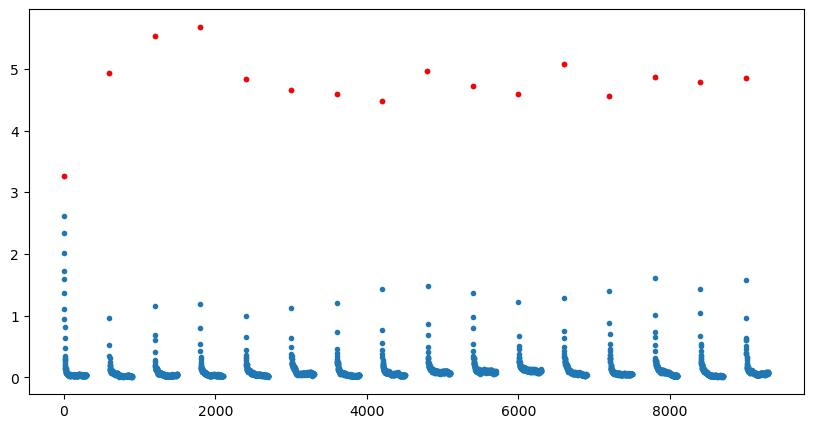

22


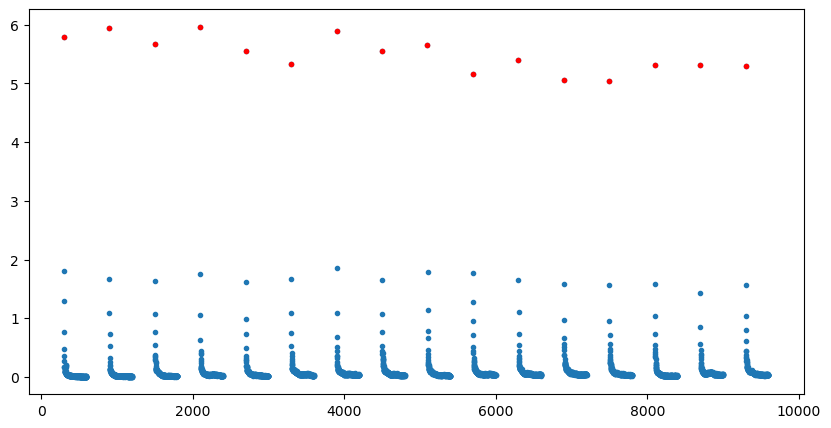

Mean slope across replicates: -0.08275686274509803
p-value (|slope| > 0): 0.025853924870084928
Mean slope across replicates: 0.013112745098039225
p-value (|slope| > 0): 0.6421002231666719
126


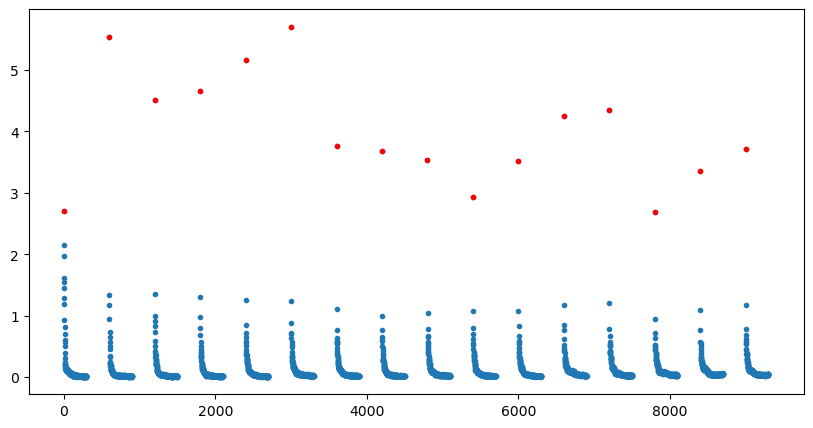

126


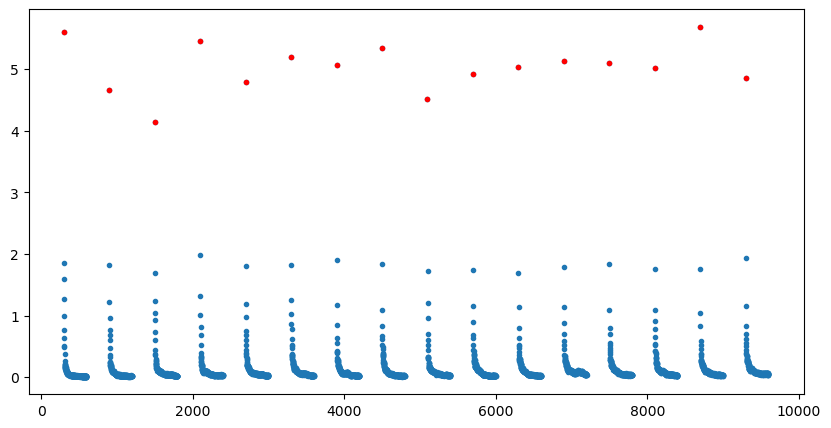

Mean slope across replicates: -0.03396470588235294
p-value (|slope| > 0): 0.23754190611634476
Mean slope across replicates: -0.007280392156862747
p-value (|slope| > 0): 0.7707073027369127
154


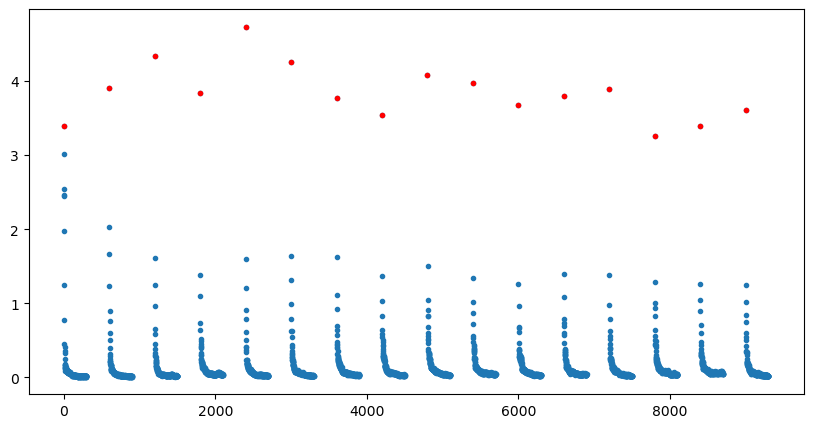

154


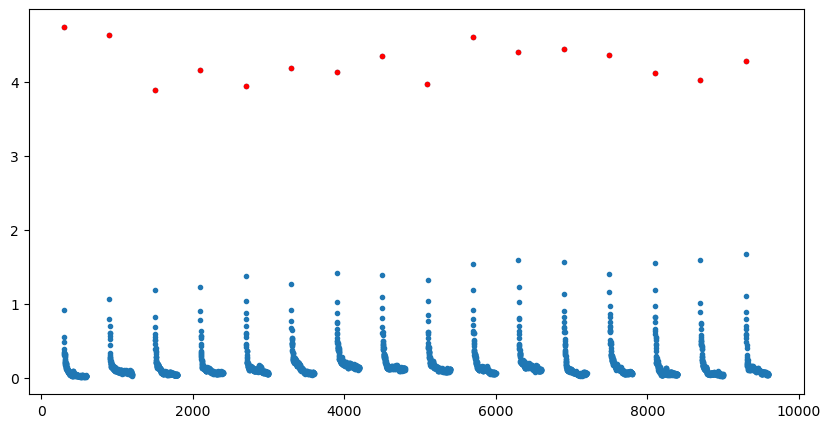

Mean slope across replicates: 0.046007843137254895
p-value (|slope| > 0): 0.08739636945507397
Mean slope across replicates: -0.012383333333333331
p-value (|slope| > 0): 0.5207351738957514
18


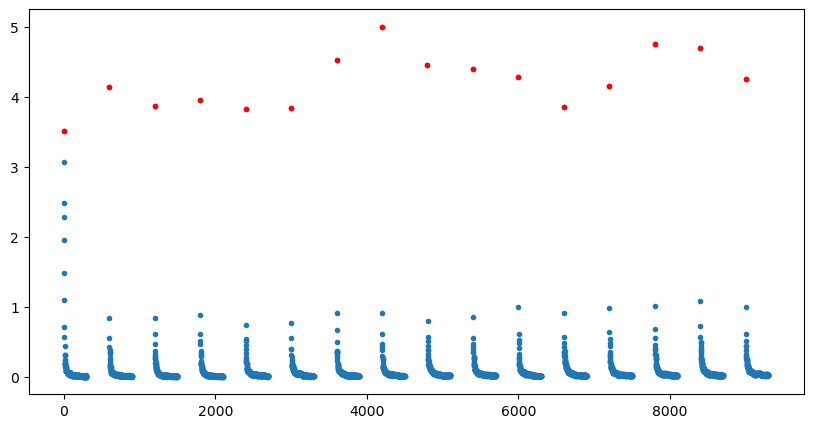

18


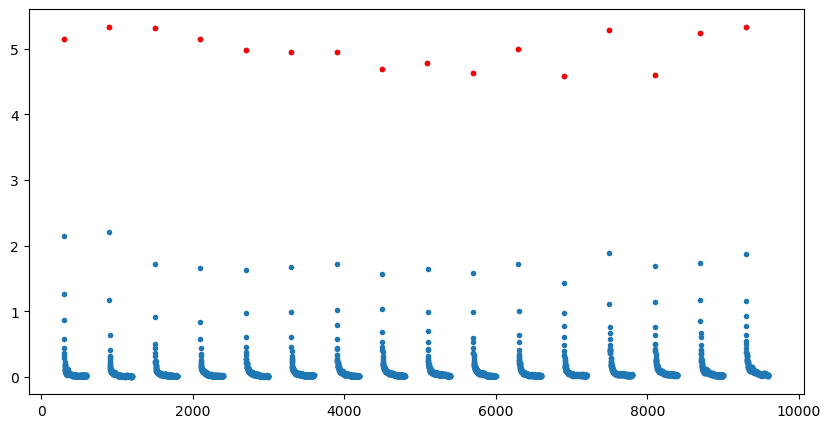

Mean slope across replicates: 0.03281274509803921
p-value (|slope| > 0): 0.2117695190671556
Mean slope across replicates: -0.01167156862745098
p-value (|slope| > 0): 0.26525709149591936
122


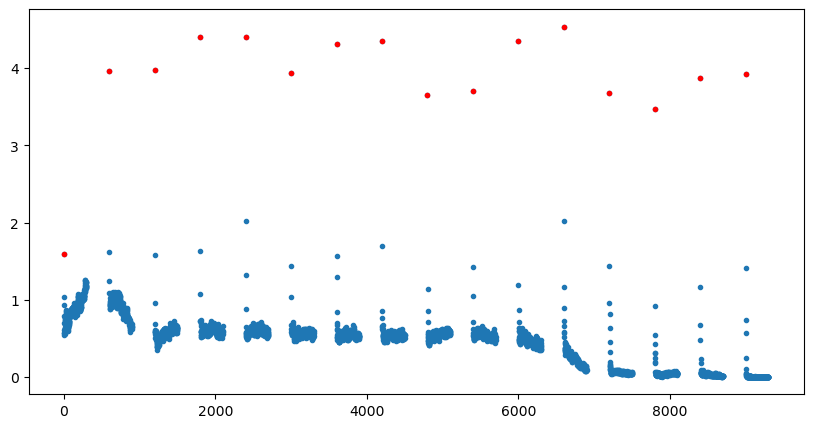

122


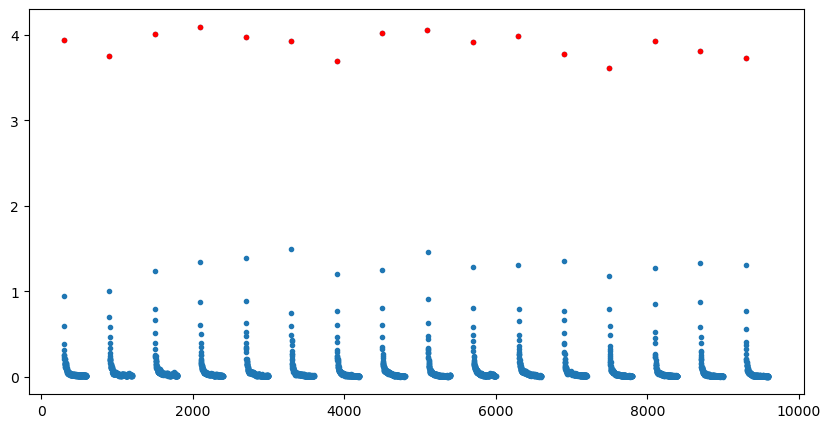

Mean slope across replicates: -0.018304901960784315
p-value (|slope| > 0): 0.42418908577506154
Mean slope across replicates: -0.07638725490196079
p-value (|slope| > 0): 0.0045734778791888305
70


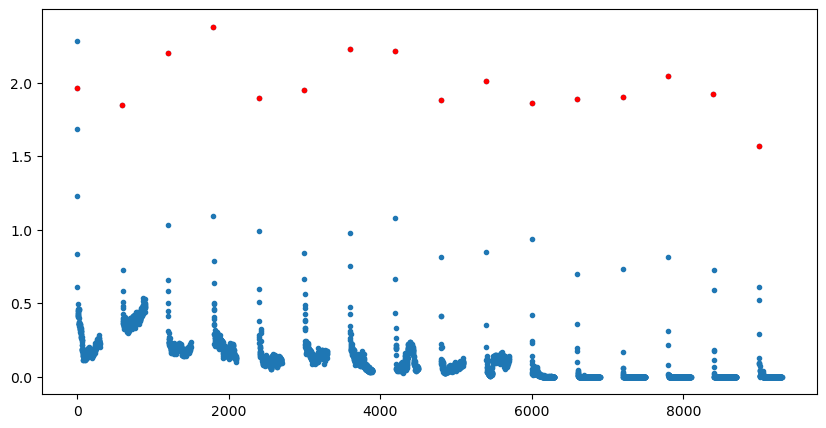

70


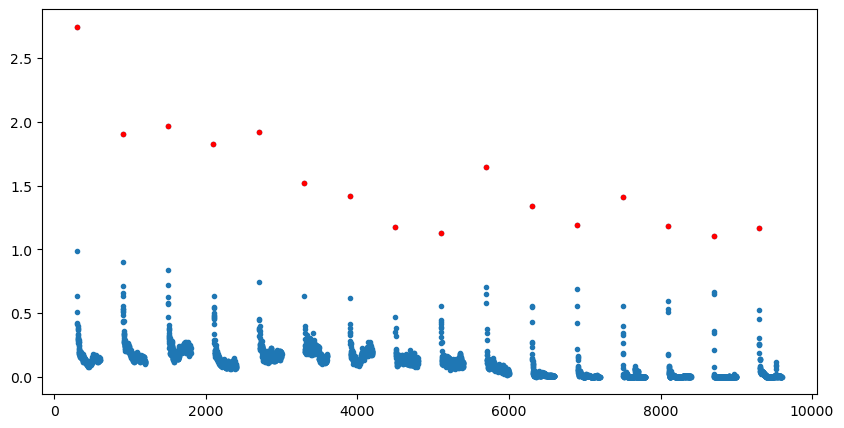

Mean slope across replicates: 0.02607058823529412
p-value (|slope| > 0): 0.059444250872260934
Mean slope across replicates: 0.07732254901960783
p-value (|slope| > 0): 0.0037285266852124838
54


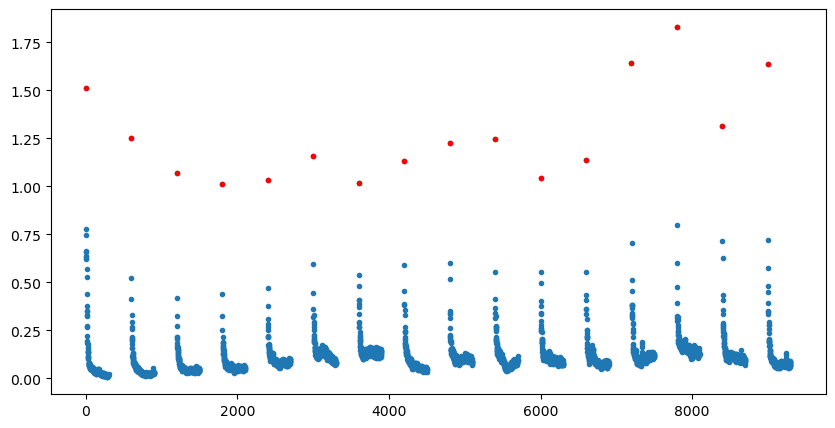

54


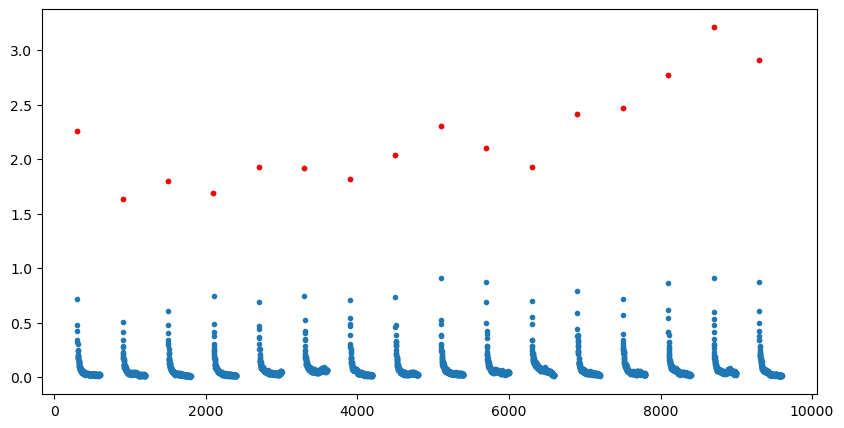

Mean slope across replicates: 0.07256862745098042
p-value (|slope| > 0): 0.004281475205377732
Mean slope across replicates: -0.05910686274509806
p-value (|slope| > 0): 0.011846962030899444
94


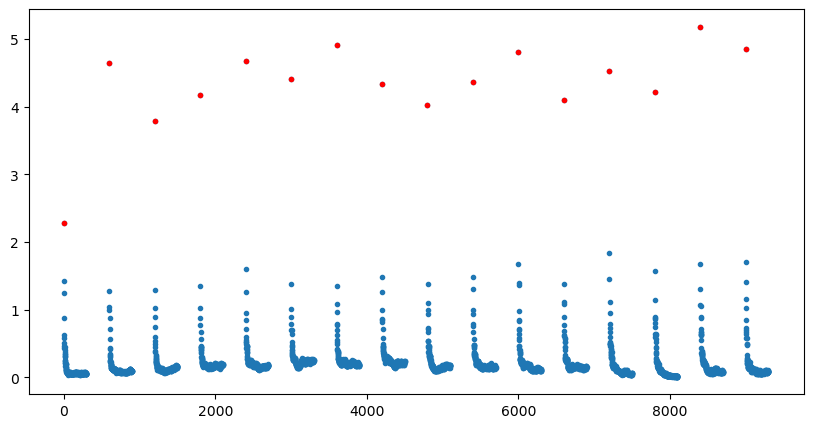

94


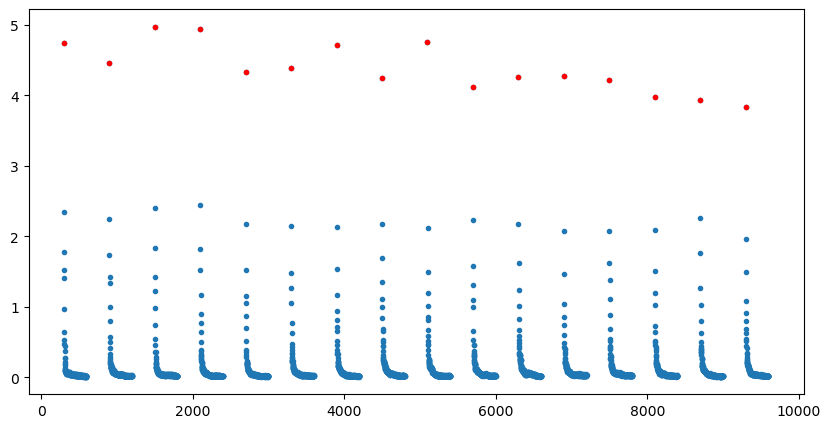

Mean slope across replicates: 0.0889392156862745
p-value (|slope| > 0): 0.004175207399674767
Mean slope across replicates: 0.06181078431372549
p-value (|slope| > 0): 0.04608874662079205
30


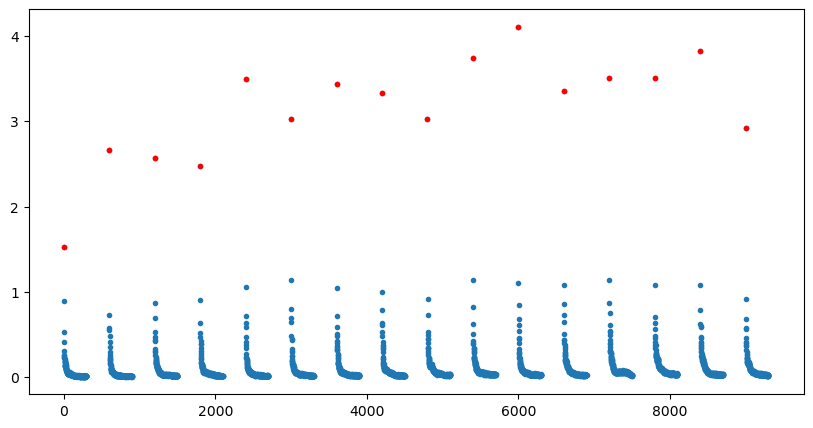

30


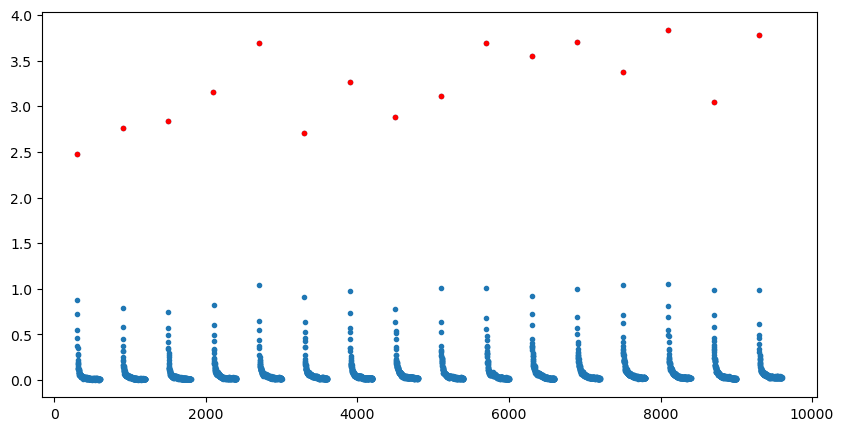

Mean slope across replicates: -0.03992058823529411
p-value (|slope| > 0): 0.1726099535673049
Mean slope across replicates: -0.10822647058823527
p-value (|slope| > 0): 2.7134092883431687e-05
50


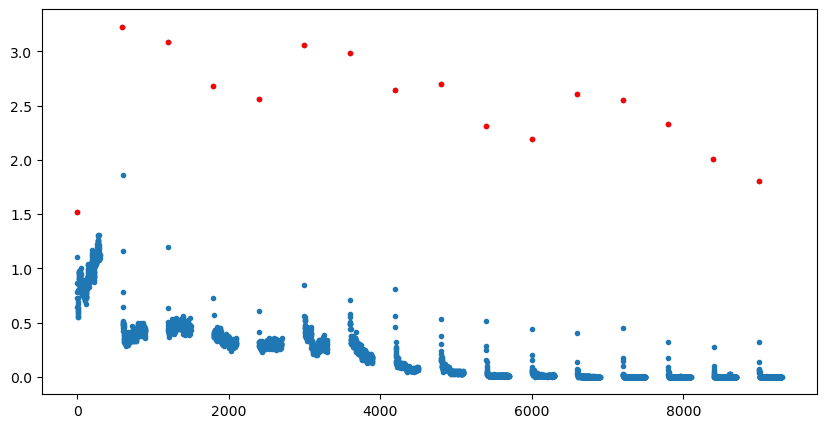

50


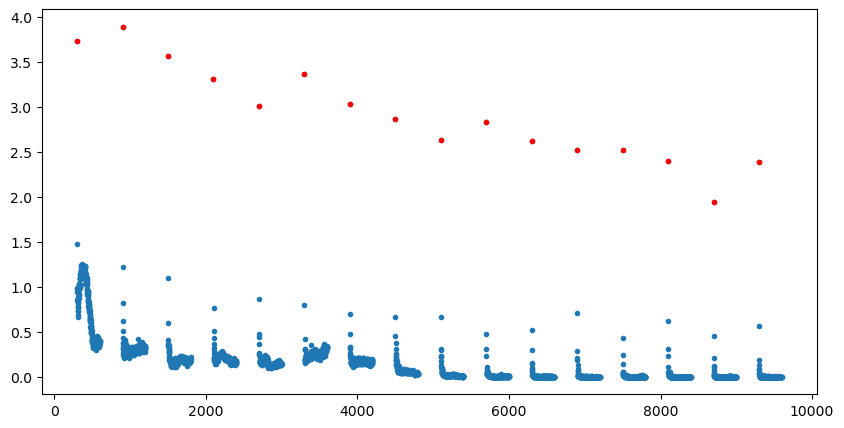

Mean slope across replicates: 0.016674509803921565
p-value (|slope| > 0): 0.4661656369367161
Mean slope across replicates: -0.025538235294117657
p-value (|slope| > 0): 0.35576094458019725
62


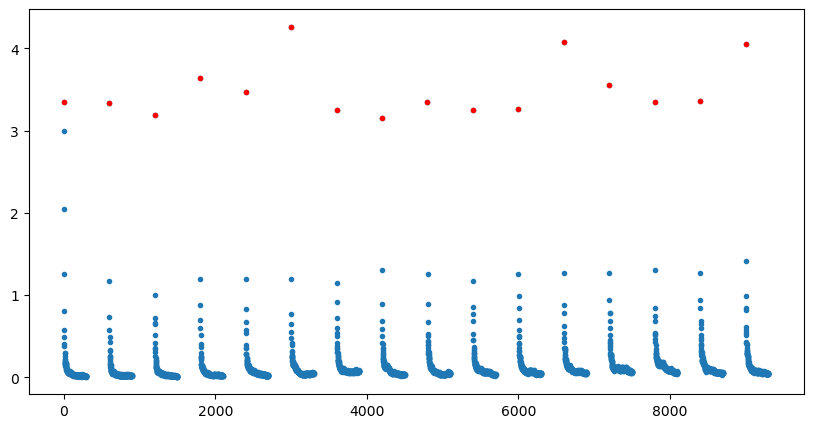

62


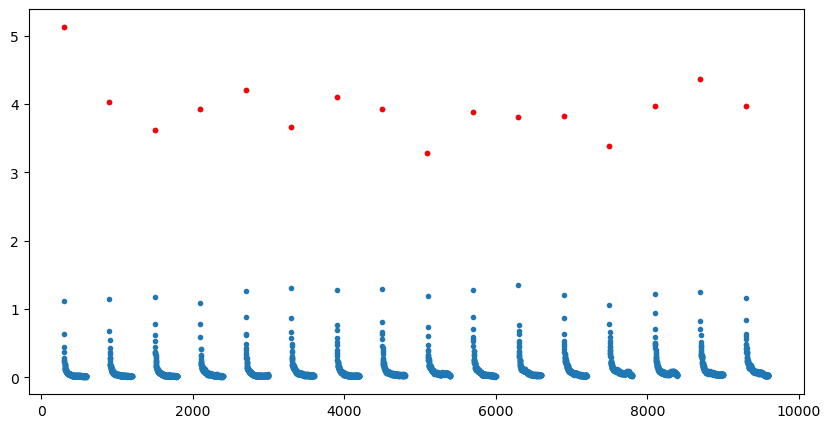

Mean slope across replicates: -0.0022215686274509833
p-value (|slope| > 0): 0.9074312822830854
Mean slope across replicates: 0.030718627450980394
p-value (|slope| > 0): 0.25331968859451304
110


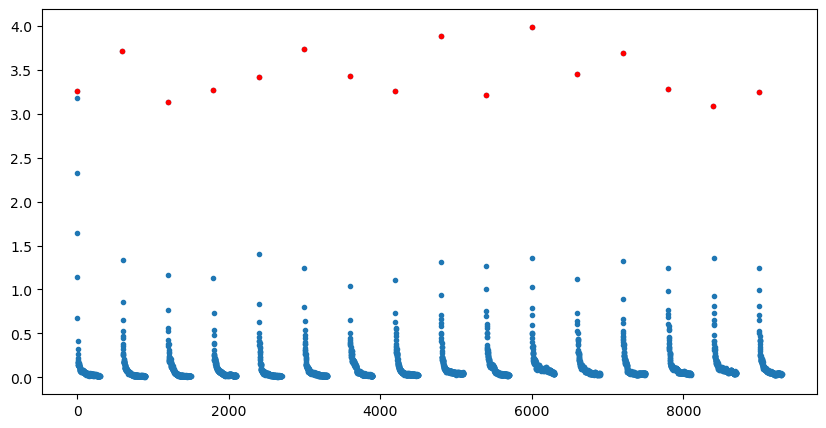

110


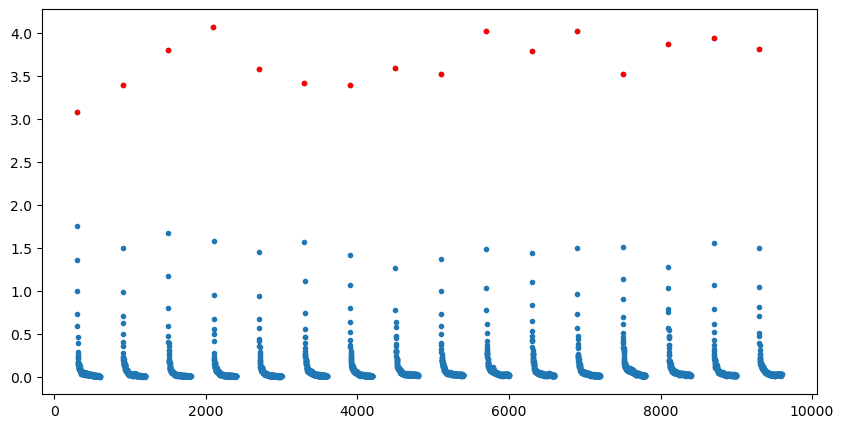

Mean slope across replicates: 0.03628823529411764
p-value (|slope| > 0): 0.042630244140630616
Mean slope across replicates: -0.015847058823529415
p-value (|slope| > 0): 0.44499161819022215
90


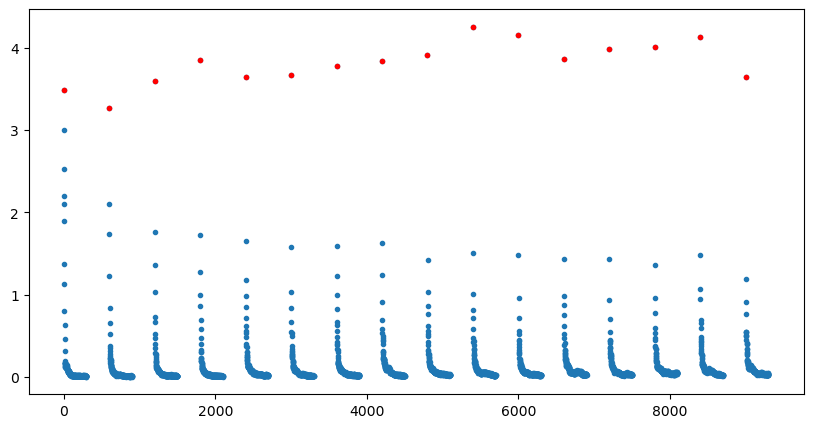

90


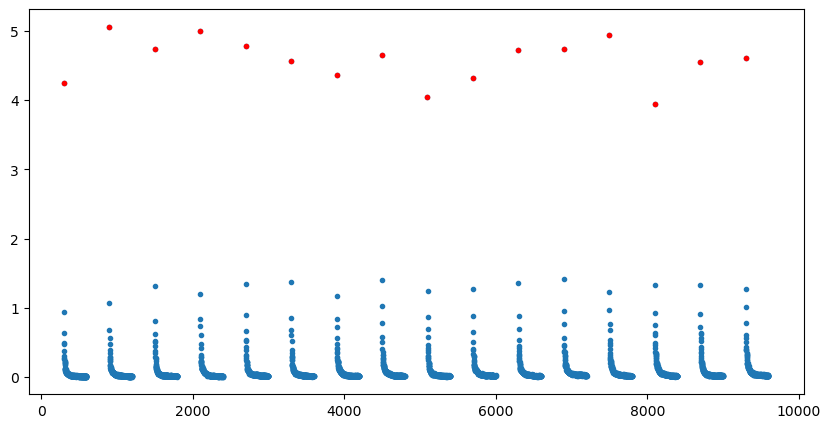

Mean slope across replicates: 0.067528431372549
p-value (|slope| > 0): 0.0020922178583299257
Mean slope across replicates: -0.005631372549019609
p-value (|slope| > 0): 0.7290932633125563
150


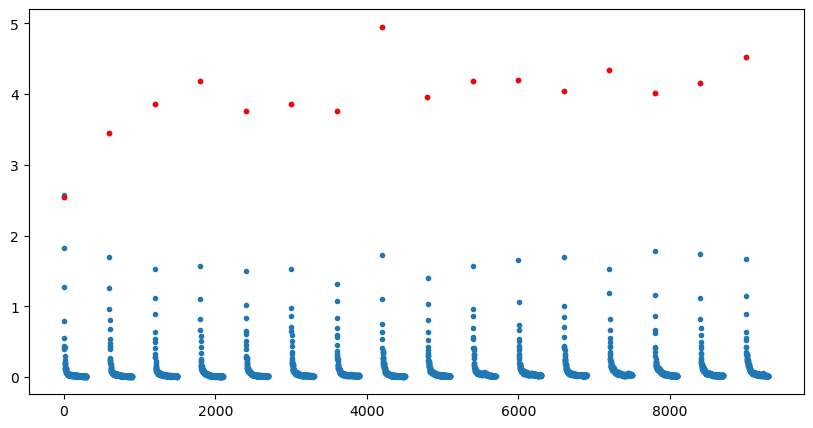

150


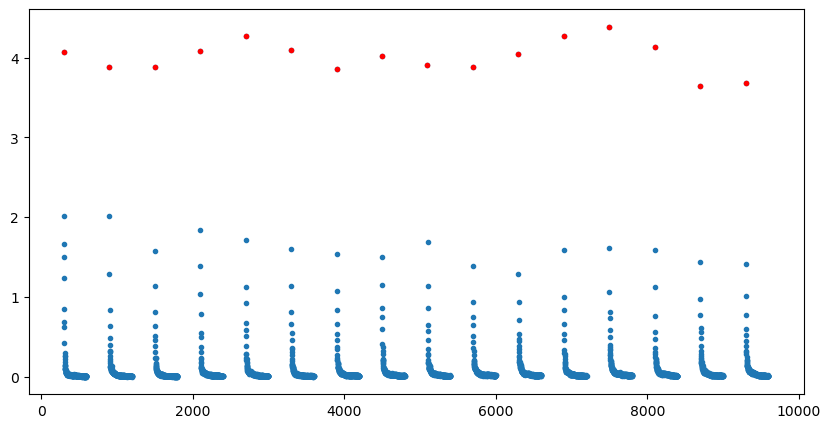

Mean slope across replicates: -0.051796078431372565
p-value (|slope| > 0): 0.09824427757246432
Mean slope across replicates: 0.03240098039215686
p-value (|slope| > 0): 0.46250680796345367
102


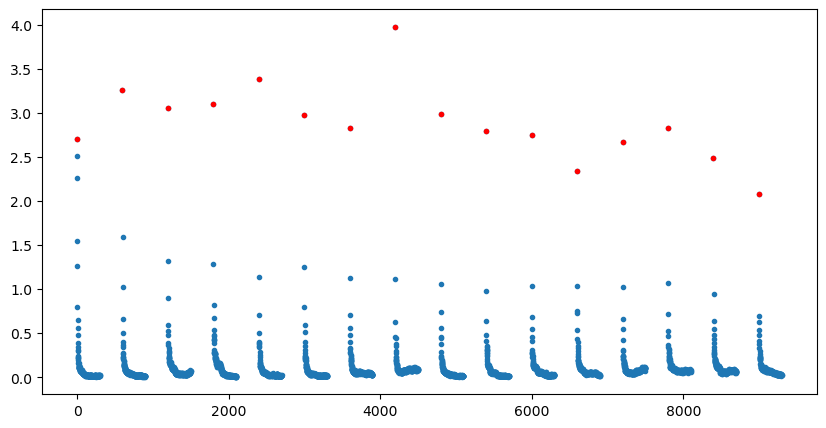

102


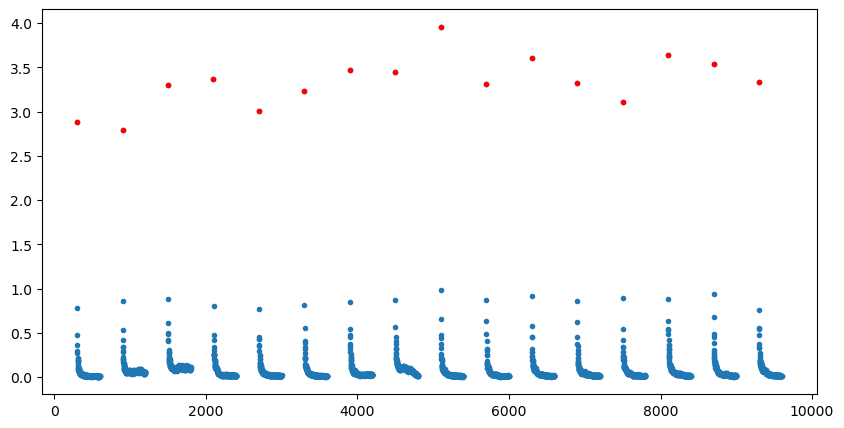

In [4]:
#PERCENT KIDS BETTER THAN PARENTS
#At season change, so gen 299 the kids have input 1, not input 0
#in this code below, the kids are compared to their parents with the same initial condition (input 1)
#in the season 0 list the last gens are 298, 898, 1498, etc and the first gens are 0, 599, 1199

rules = [22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150, 102]

#>= or just >, plot both! need to slopify and it's done. 
# also, yes, surviving parent is counted in the == but that is the case every generation so it won't influence slope 

all_props1=[]
all_props2=[]
pdic=[]
for rule in rules:
    with open(f'kid_fits_{rule}.p', 'rb') as f:
        kid_fits = pickle.load(f)

    ave_nums_higher1=[]
    ave_nums_higher2=[]
    for rep in range(15):
        s1 = chunked_gens[0::2]
        new_col = (s1[:, 0] - 1).reshape(-1, 1) #adding the last gen of previous season as kids of that gen used this season input
        gens1 = np.hstack((new_col, s1))[:,:-1].flatten() #removing the last gen of the season as kids of that gen used next season input
        gens1 = gens1[1:] #fixing the fact that the first season (ever) is not kids of a previous gen
        curr = 0
        num_higher = np.sum(kid_fits[rep,gens1,curr,:,:] > kid_fits[rep,gens1,curr,:,0][..., np.newaxis], axis = -1) #first in list is parent
        num_higher = num_higher.mean(axis=1) #average across parents
        ave_nums_higher1.append(num_higher)

        s2 = chunked_gens[1::2]
        new_col = (s2[:, 0] - 1).reshape(-1, 1) #same reason as above
        gens2 = np.hstack((new_col, s2))[:,:-1].flatten()
        curr = 1
        num_higher = np.sum(kid_fits[rep,gens2,curr,:,:] > kid_fits[rep,gens2,curr,:,0][..., np.newaxis], axis = -1) #first in list is parent
        num_higher = num_higher.mean(axis=1) #average across parents
        ave_nums_higher2.append(num_higher)
    ave_nums_higher1 = np.array(ave_nums_higher1)
    ave_nums_higher2 = np.array(ave_nums_higher2)

    ave_nums_higher_mean1 = np.mean(ave_nums_higher1, axis=0) #average across replicates
    ave_nums_higher_mean2 = np.mean(ave_nums_higher2, axis=0) #average across replicates

    mystats=True
    if mystats:
        at_switch1_y = np.insert(ave_nums_higher1[:,299::300], 0, ave_nums_higher1[:,0], axis = 1) 
        at_switch2_y = ave_nums_higher2[:,::300] 

        for s in [at_switch1_y, at_switch2_y]:
            time = np.arange(s.shape[1])
            # Fit linear regression for each replicate to get the slope
            slopes = []
            for replicate in s:
                slope, intercept, r_value, p_value, std_err = stats.linregress(time, replicate)
                slopes.append(slope)
            slopes = np.array(slopes)
            # Now test if the average slope is significantly greater than zero
            #This is a test for the null hypothesis that the expected value (mean) of a sample of 
            # independent observations _slopes_ is equal to the given number, 0.
            t_stat, p_val = stats.ttest_1samp(slopes, 0)

            print("Mean slope across replicates:", slopes.mean())
            print("p-value (|slope| > 0):", p_val)

            pdic.append(p_val)

    z_value = 1.96
    stderr1 = np.std(ave_nums_higher_mean1, axis=0) / np.sqrt(15)
    ci_upper = ave_nums_higher_mean1 + z_value * stderr1
    ci_lower = ave_nums_higher_mean1 - z_value * stderr1
    fig, ax=plt.subplots(nrows=1,ncols=1, figsize=(10, 5),sharex=True)
    ax.plot(gens1,ave_nums_higher_mean1, ".")
    at_switch1_y = np.insert(ave_nums_higher_mean1[299::300], 0, ave_nums_higher_mean1[0]) 
    at_switch1_x = np.insert(gens1[299::300], 0, 0)
    all_props1.append(at_switch1_y)
    
    ax.plot(at_switch1_x,at_switch1_y, ".", color="red") #first time this target is considered for kids 0, 599, 1199, etc
    print(rule)
    plt.show()

    stderr1 = np.std(ave_nums_higher_mean2, axis=0) / np.sqrt(15)
    ci_upper = ave_nums_higher_mean2 + z_value * stderr1
    ci_lower = ave_nums_higher_mean2 - z_value * stderr1
    fig, ax=plt.subplots(nrows=1,ncols=1, figsize=(10, 5),sharex=True)
    ax.plot(gens2,ave_nums_higher_mean2, ".")
    at_switch2_y = ave_nums_higher_mean2[::300] 
    at_switch2_x = gens2[::300]
    all_props2.append(at_switch2_y)

    ax.plot(at_switch2_x,at_switch2_y, ".", color="red")
    print(rule)
    plt.show()
    

In [5]:
from statsmodels.stats.multitest import multipletests

fdr = multipletests(np.array(pdic), method='fdr_bh')[1]
labs=list(zip(np.repeat(rules, 2), np.array([0,1]*15)))
c=0
sign = []
for f in fdr:
    if f < 0.05:
        print(labs[c])
        sign.append(labs[c][0])
    c+=1
print(sign)

(70, 1)
(54, 1)
(94, 0)
(30, 0)
(50, 1)
(150, 0)
[70, 54, 94, 30, 50, 150]


/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


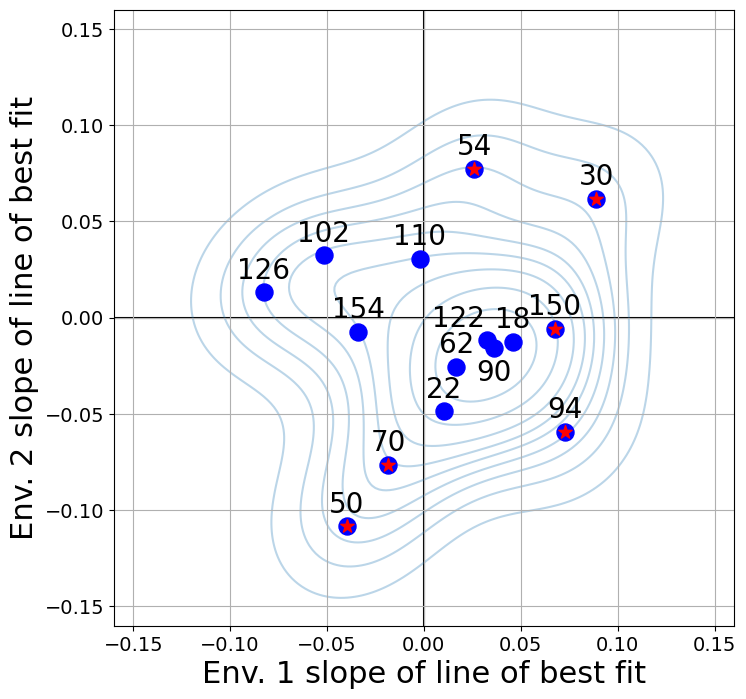

In [6]:
def get_slopes(xs):
    outs=[]
    for i in range(15):
        slope, intercept = np.polyfit(np.arange(0,len(xs[i])), xs[i], 1)
        outs.append(slope)
    return outs

# x=get_slopes(all_props10)
# y=get_slopes(all_props20)
# sns.kdeplot(x = x, y = y,fill=False,thresh=0.1,zorder=1,alpha=0.5,c="C0")
# plt.plot(x,y,".",c="C0")
#for xi, yi, label in zip(x, y, rules):
    #plt.text(xi, yi, label, fontsize=12, ha='right', va='bottom')

nrows,ncols = 1,1
scale = 8
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*scale, nrows*scale), sharex="row", sharey="row")

x=get_slopes(all_props1)
y=get_slopes(all_props2)
plt.grid(zorder = 0)
sns.kdeplot(x = x, y = y,fill=False,thresh=0.1,zorder=1,alpha=0.3)
plt.scatter(x,y,c="blue", alpha=1,s=150,zorder=2)
for xi, yi, label in zip(x, y, rules):
    if label == 122:
        plt.text(xi-0.015, yi+0.004, label, fontsize=20, ha='center', va='bottom')
    elif label ==90:
        plt.text(xi, yi-0.02, label, fontsize=20, ha='center', va='bottom')
    else:
        plt.text(xi, yi+0.004, label, fontsize=20, ha='center', va='bottom')
    if label in sign:
        plt.scatter(xi, yi, color='red', marker='*', s=100,zorder=3)

plt.axvline(0,color="black",zorder = 0)
plt.axhline(0,color="black",zorder = 0)
plt.ylim(-0.16,0.16)
plt.xlim(-0.16,0.16)
plt.xlabel("Env. 1 slope of line of best fit", fontsize=22)
plt.ylabel("Env. 2 slope of line of best fit", fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=14)

#plt.set_axisbelow(True)
plt.show()

In [76]:
rules

[22, 126, 154, 18, 122, 70, 54, 94, 30, 50, 62, 110, 90, 150, 102]

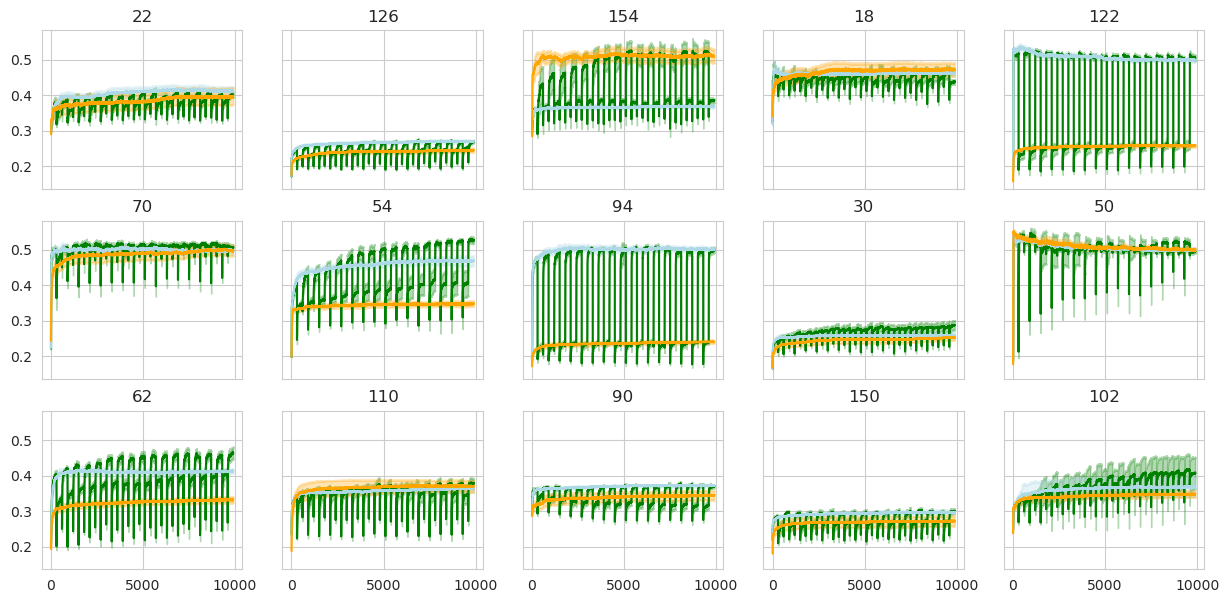

In [4]:
num_reps = 15
z_value = 1.96  # For a 95% confidence interval
labels=["vari","env1","env2"]
colors = ["green", "lightblue", "orange"]

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),sharex=True, sharey=True)
axes = axes.flatten()

rules = [22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150,102]

for idx, rule in enumerate(rules):

    div_BH_mean = pickle.load(open(f"diversify_{rule}.p", "rb"))
    
    for i in range(3):
        mean1 = div_BH_mean[i,:,:].mean(axis = 0)
        stderr1 = np.std(div_BH_mean[i,:,:], axis=0) / np.sqrt(num_reps)
        ci_upper = mean1 + z_value * stderr1
        ci_lower = mean1 - z_value * stderr1
        axes[idx].fill_between(range(len(mean1)), ci_lower, ci_upper, alpha=0.3,color=colors[i])
        axes[idx].plot(mean1, "-", label= labels[i], color=colors[i])
        axes[idx].set_title(f"{rule}")
    #plt.legend()